In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

test=pd.read_csv('../input/Kannada-MNIST/test.csv')
train=pd.read_csv('../input/Kannada-MNIST/train.csv')
val=pd.read_csv('../input/Kannada-MNIST/Dig-MNIST.csv')
sub=pd.read_csv('../input/Kannada-MNIST/sample_submission.csv')

Using TensorFlow backend.


In [2]:
y_train=train.pop('label')
x_train=train

y_val=val.pop('label')
x_val=val

x_train/=255.0
x_val/=255.0

test.drop(columns=['id'], inplace=True)
test/=255.0

In [3]:
x_train=x_train.values.reshape(-1, 28, 28, 1)
x_val=x_val.values.reshape(-1, 28, 28, 1)
test=test.values.reshape(-1, 28, 28, 1)

In [4]:
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=2)

In [5]:
EPOCHS = 50
BATCH_SIZE = 64

In [6]:
datagen=ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

In [7]:
datagen.fit(x_train)

In [8]:
reduceLR = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 3, 
    verbose = 1, 
    factor = 0.3, 
    mode = 'min',
    min_lr = 0.00001
)

checkpoint = ModelCheckpoint(
    'weights.h5', 
    monitor = 'val_accuracy', 
    verbose = 1, 
    save_best_only = True, 
    mode = 'max'
)

early_stopping = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 1e-10, 
    patience = 10, 
    verbose = 1, 
    restore_best_weights = True
)

callbacks=[reduceLR, checkpoint, early_stopping]

In [9]:
model=Sequential([
    Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, kernel_size = 3, activation='relu'),
    BatchNormalization(),
    Conv2D(32, kernel_size = 5, strides=2, padding = 'same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Conv2D(64, kernel_size = 3, activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size = 3, activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size = 5, strides=2, padding = 'same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Conv2D(128, kernel_size = 4, activation='relu'),
    BatchNormalization(),
    
    Flatten(),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

In [10]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)       

In [12]:
#history=model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=20, batch_size=320)
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data = (x_val, y_val),
    steps_per_epoch = len(x_train) / BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = callbacks
)

Epoch 1/50
938/937 [==============================] - 35s 38ms/step - loss: 0.6149 - accuracy: 0.7971 - val_loss: 0.8722 - val_accuracy: 0.7803

Epoch 00001: val_accuracy improved from -inf to 0.78027, saving model to weights.h5
Epoch 2/50
938/937 [==============================] - 33s 35ms/step - loss: 0.1666 - accuracy: 0.9485 - val_loss: 0.5595 - val_accuracy: 0.8608

Epoch 00002: val_accuracy improved from 0.78027 to 0.86084, saving model to weights.h5
Epoch 3/50
938/937 [==============================] - 32s 35ms/step - loss: 0.1169 - accuracy: 0.9638 - val_loss: 0.5589 - val_accuracy: 0.8609

Epoch 00003: val_accuracy improved from 0.86084 to 0.86094, saving model to weights.h5
Epoch 4/50
938/937 [==============================] - 32s 34ms/step - loss: 0.0960 - accuracy: 0.9706 - val_loss: 0.7967 - val_accuracy: 0.8132

Epoch 00004: val_accuracy did not improve from 0.86094
Epoch 5/50
938/937 [==============================] - 32s 34ms/step - loss: 0.0848 - accuracy: 0.9736 - val

In [13]:
x=pd.DataFrame(history.history)

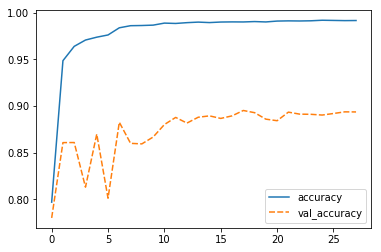

In [14]:
sns.lineplot(data = x[['accuracy', 'val_accuracy']]) 

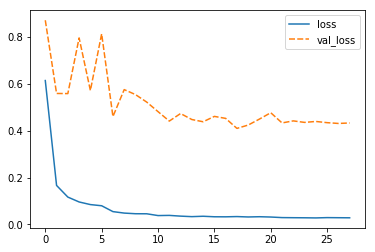

In [15]:
sns.lineplot(data = x[['loss', 'val_loss']]) 

In [16]:
pred = model.predict(test)
sub['label'] = np.argmax(pred, axis = 1)
sub.to_csv('submission.csv', index = False)